# Generate MTG cards designs with a GAN (PyTorch)

[MTG Dataset](www.kaggle.com/dataset/5807af0fb625318fa859b01fa4303595bb72b934ef4e24128dacd2f6d9f41aea)

## Environment setup

In [1]:
import os
import platform

print(f"Python version: {platform.python_version()}")
assert platform.python_version_tuple() >= ("3", "6")

import matplotlib
import matplotlib.pyplot as plt

Python version: 3.9.7


In [2]:
# Setup plots
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8
%config InlineBackend.figure_format = 'retina'

In [3]:
import torch

print(f"PyTorch version: {torch.__version__}")
print("GPU found :)" if torch.cuda.is_available() else "No GPU :(")

import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PyTorch version: 1.10.0+cpu
No GPU :(


In [4]:
import random

#set manual seed
manualSeed = 777
print("Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Seed:  777


In [10]:
# Hyper-parameters
image_size = 56
latent_size = 100
gen_channels = 64
dis_channels = 64
batch_size = 100

## Data loading

In [5]:
sample_dir = "samples"

# Create a directory if not exists
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

evaluated_dir = "evaluate"

# Create a directory if not exists
if not os.path.exists(evaluated_dir):
    os.makedirs(evaluated_dir)

# Image processing
transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=0.5, std=0.5),  # only one channel
    ]
)

# MTG Cards dataset
from torchvision.datasets import ImageFolder
dataset = ImageFolder(root="../input/mtg-56-56", transform=transform)

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: '../input/mtg-56-56'

Create batch data loader `data_loader` for training dataset.

In [ ]:
# Create the dataloader
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2, drop_last=True)

## Model definition

- generator must be a dense network with two hidden layers using ReLU as activation functions, and an output layer using tanh;
- discriminator must be a dense network with two hidden layers using leaky ReLU (with $\alpha=0.2$) as activation functions, and an output layer using sigmoid.

In [ ]:
# Generator
G = nn.Sequential(
    # input is latent size, output is 256
    nn.ConvTranspose2d(latent_size, gen_channels * 8, 4, 2, 0, bias=False),
    nn.BatchNorm2d(gen_channels * 8),
    nn.ReLU(True),
    # state size. (gen_channels*8) x 4 x 4
    nn.ConvTranspose2d(gen_channels * 8, gen_channels * 4, 3, 2, 1, bias=False),
    nn.BatchNorm2d(gen_channels * 4),
    nn.ReLU(True),
    # state size. (gen_channels*7) x 7 x 7
    nn.ConvTranspose2d(gen_channels * 4, gen_channels * 2, 4, 2, 1, bias=False),
    nn.BatchNorm2d(gen_channels * 2),
    nn.ReLU(True),
    # state size. (gen_channels*2) x 14 x 14
    nn.ConvTranspose2d(gen_channels * 2, gen_channels * 1, 4, 2, 1, bias=False),
    nn.BatchNorm2d(gen_channels * 1),
    nn.ReLU(True),
    # state size. (gen_channels*1) x  28 x 28
    nn.ConvTranspose2d(gen_channels * 1, 3, 4, 2, 1, bias=False),
    nn.Tanh()
    # state size. (3 colors) x 56 x 56
)

# Discriminator
D = nn.Sequential(
    # input is (3 colors) x 56 x 56   
    nn.Conv2d(3, dis_channels, 4, 2, 1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),
    # input is (dis_channels) x 28 x 28    
    nn.Conv2d(dis_channels, dis_channels * 2, 4, 2, 1, bias=False),    
    nn.BatchNorm2d(dis_channels * 2),
    nn.LeakyReLU(0.2, inplace=True),
    # state size. (dis_channels * 2) x 14 x 14
    nn.Conv2d(dis_channels * 2, dis_channels * 4, 4, 2, 1, bias=False),
    nn.BatchNorm2d(dis_channels * 4),
    nn.LeakyReLU(0.2, inplace=True),
    # state size. (dis_channels*4) x 7 x 7
    nn.Conv2d(dis_channels * 4, dis_channels * 8, 3, 2, 1, bias=False),
    nn.BatchNorm2d(dis_channels * 8),
    nn.LeakyReLU(0.2, inplace=True),
    # state size. (dis_channels*8) x 4 x 4
    nn.Conv2d(dis_channels * 8, 1, 4, 2, 0, bias=False),
    nn.Sigmoid()
)

# Device setting
G = G.to(device)
D = D.to(device)

## Loss, optimizer and utilities

Define optimizers `d_optimizer` and `g_optimizer`, both using Adam with  a learning rate of 0.0002.

In [ ]:
# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [14]:
def denorm(x):
    """Denormalize an image tensor"""
    out = (x + 1) / 2
    return out.clamp(0, 1)


def reset_grad():
    """Reset gradients for both optimizers"""
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [ ]:
# custom weights initialization called on generator and discriminator
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
D.apply(weights_init)
G.apply(weights_init)

## Model training

- compute fake images and output during discriminator training;
- implement gradient descent.

In [ ]:
num_epochs = 101 # Increase for a better output quality
step_count = len(data_loader)

evaluated_images = torch.randn(batch_size, latent_size, 1, 1, device=device)

# Start training
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.to(device)
        
        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, device=device)
        fake_labels = torch.zeros(batch_size, device=device)
        
        #reset gradient on optimizers
        reset_grad()
        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        D.zero_grad()
        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since y == real_labels == 1        
        real_outputs = D(images).view(-1)
        d_loss_real = criterion(real_outputs, real_labels)
        # Calculate gradients for D in backward pass
        d_loss_real.backward()
        real_score = real_outputs

        # Compute BCELoss using fake images
        # First term of the loss is always zero since y == fake_labels == 0
        z = torch.randn(batch_size, latent_size, 1, 1, device=device)
        # Generate fake image batch with G
        fake_images = G(z)
        fake_outputs = D(fake_images.detach()).view(-1)
        d_loss_fake = criterion(fake_outputs, fake_labels)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        d_loss_fake.backward()
        fake_score = fake_outputs

        # Update Discriminator
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.step()

        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #
        G.zero_grad()
        z = torch.randn(batch_size, latent_size, 1, 1, device=device)
        # Generate fake image batch with G
        fake_images = G(z)
        outputs = D(fake_images).view(-1)
        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        g_loss = criterion(outputs, real_labels)

        # Backprop and optimize
        g_loss.backward()
        D_G_z2 = outputs.mean().item()
        # Update Generator
        g_optimizer.step()

        if (i + 1) % 50 == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}]"
                f", Step [{i + 1}/{step_count}]"
                f", d_loss: {d_loss.item():.4f}"
                f", g_loss: {g_loss.item():.4f}"
                f", D(x): {real_score.mean().item():.2f}"
                f", D(G(z)): {fake_score.mean().item():.2f}"
            )

    # Save real images
    if (epoch + 1) == 1:
        #images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, "real_images.png"))

    # Save sampled images
    if (epoch + 1) % 5 == 0:
        #fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
        save_image(
            denorm(fake_images),
            os.path.join(sample_dir, f"fake_images-{epoch + 1}.png"),
        )
    
    # Save evaluate image in order to create a GIF with illustrate the generation of a images through epoches
    save_image(
        denorm(G(evaluated_images)),
        os.path.join(evaluated_dir, f"evaluated_images-{epoch + 1}.png"), 
        nrow=10,
    )

## Generate images

In [28]:
def plot_image(image):
    # Convert PyTorch tensor to NumPy
    img_tensor = image.cpu().numpy() if torch.cuda.is_available() else image.numpy()    
    img_tensor = img_tensor.transpose(1, 2, 0)
    plt.imshow(img_tensor.squeeze())
    plt.axis("off")

def show_images(images, n_images=batch_size):
    fig = plt.figure(figsize=(10, 10))
    for image_index in range(n_images):
        plt.subplot(10, 10, 1 + image_index)
        plot_image(images[image_index])

Print the last generated date and create a GIF that illustrate the training

In [ ]:
with torch.no_grad():
    show_images(denorm(fake_images))

In [ ]:
import matplotlib.image as mpimg
import matplotlib.animation as animation
def make_a_gif():
    name = "evaluation"
    fig = plt.figure(figsize=(10, 10))
    plt.axis('off')
    ims = []
    for epoch in range(0, num_epochs):
        image = mpimg.imread(f"./evaluate/evaluated_images-{epoch + 1}.png")
        ims.append([plt.imshow((image), cmap="binary", animated=True), plt.text(251,-10, f"Epoch : {epoch + 1}",horizontalalignment='center',
     verticalalignment='center')])
    ani = animation.ArtistAnimation(fig, ims)
    ani.save(name + ".gif")
    plt.tight_layout()
    plt.show()

In [ ]:
#save a gif of images generated at each epochs
make_a_gif()

![MODEL](./evaluation.gif)

In [ ]:
torch.save(G, "gen_gan_mtg.model")
torch.save(D, "dis_gan_mtg.model")

## Reload model

**Warning** Comment model definition and weight load

Use the trained generator to create fake images from Gaussian noise.

In [22]:
G = torch.load("./gen_gan_mtg.model", map_location=device)
D = torch.load("./dis_gan_mtg.model", map_location=device)

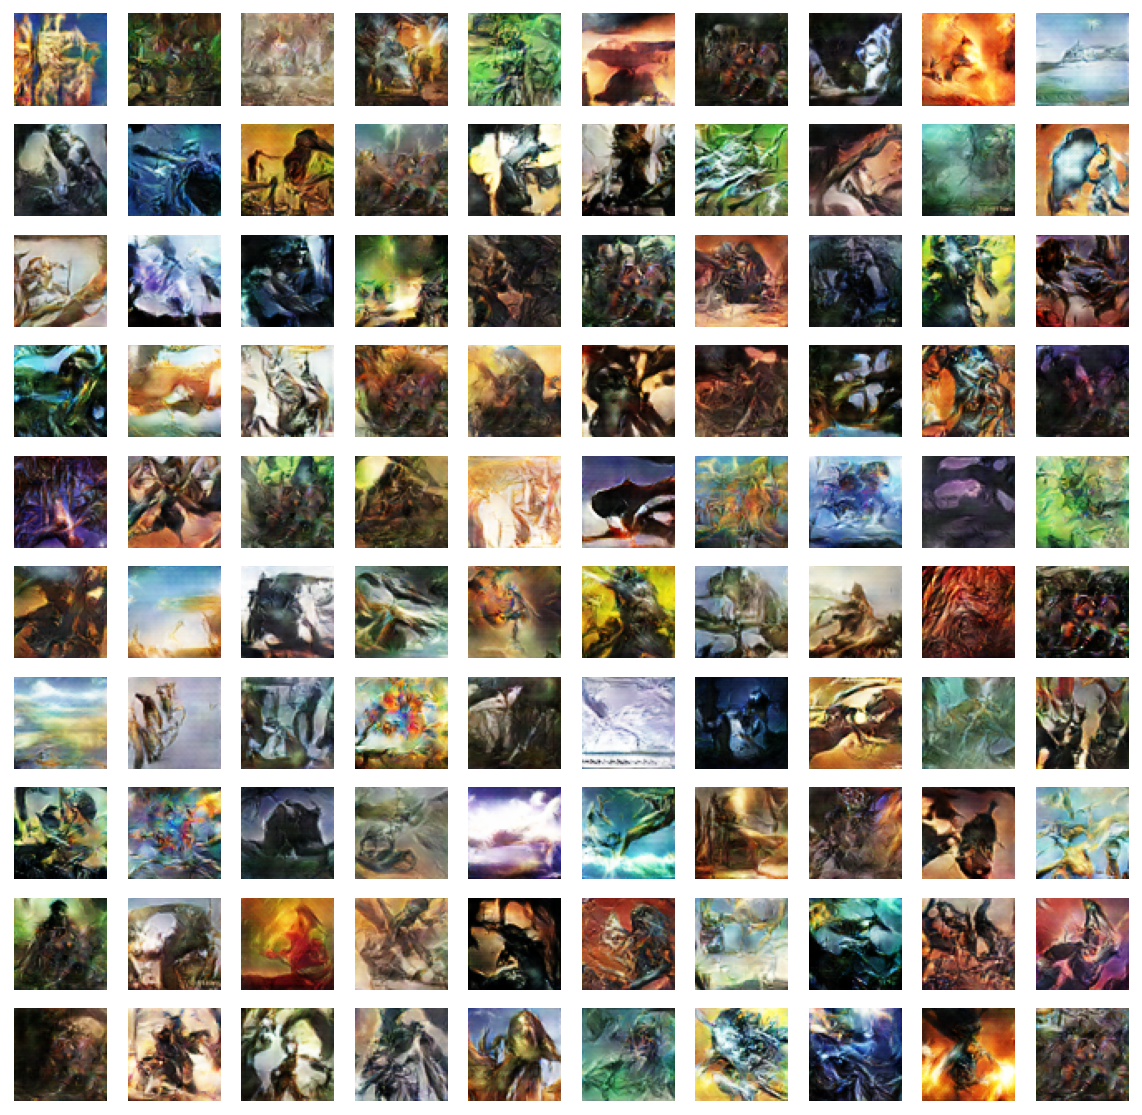

In [37]:
#Random images
z = torch.randn(batch_size, latent_size, 1, 1)
images = denorm(G(z).detach())

fig = plt.figure(figsize=(10, 10))
with torch.no_grad():
    for image_index in range(batch_size):
        plt.subplot(10, 10, 1 + image_index)
        image = images[image_index]
        img_tensor = image.cpu().numpy() if torch.cuda.is_available() else image.numpy()
        img_tensor = img_tensor.transpose(1, 2, 0)
        plt.imshow(img_tensor.squeeze())
        plt.axis("off")


## Bibliography

- Notebook given by Baptiste PESQUET (teacher at ENSEIRB-MATMECA)
- [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434)
- [Training a DCGAN in PyTorch](https://www.pyimagesearch.com/2021/10/25/training-a-dcgan-in-pytorch/)
- [DCGAN Tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)